<img src="Title.PNG" align="left"/>

# Recommendation system

### Packages used in the project

In [ ]:
import pandas as pd            
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import pylab
from sklearn.model_selection import train_test_split
import seaborn as sns
import dython
from dython import nominal
import plotly.graph_objs as go
import plotly.offline as pyo
from sklearn.svm import OneClassSVM
from collections import Counter

### Loading data

In [2]:
df_market = pd.read_csv('estaticos_market.csv')
df_pf1 = pd.read_csv('estaticos_portfolio1.csv')
df_pf2 = pd.read_csv('estaticos_portfolio2.csv')
df_pf3 = pd.read_csv('estaticos_portfolio3.csv')

It's necessary to remove the column "Unnamed" from df_market (not important in the dataset).
Before joinning all these datasets, let's create one column for each of them:
- **ID_PF** --> It will describe in which dataset the related line comes from.

In [3]:
#Removing the column "Unnamed" from df_market
del df_market['Unnamed: 0']

# Taking infos of each dataset
df0 = df_market.copy()
df1 = df_market[df_market.id.isin(df_pf1.id)]
df2 = df_market[df_market.id.isin(df_pf2.id)]
df3 = df_market[df_market.id.isin(df_pf3.id)]

#Creating a column for each dataframe to identify the related portfolio
df0.insert(0, 'ID_PF', 'Generico')
df1.insert(0, 'ID_PF', '1')
df2.insert(0, 'ID_PF', '2')
df3.insert(0, 'ID_PF', '3')


#Join the 4 dataframes
df_total = pd.concat([df0, df1,df2,df3])

Let's see the size of the dataset *df_total*

In [4]:
df_total.shape

(463684, 182)

### Missing values analysis
In the next step, it's necessary to check if there is any missing value

In [5]:
df_total.isna().sum()

ID_PF                           0
id                              0
fl_matriz                       0
de_natureza_juridica            0
sg_uf                           0
                            ...  
qt_funcionarios_24meses    359148
tx_crescimento_12meses     388869
tx_crescimento_24meses     388750
tx_rotatividade            359148
qt_filiais                      0
Length: 182, dtype: int64

As we can see, there are a lot of missing values. My strategy was remove the variables that has more then 230.000 missing values (it represents 50% of missing values)

In [4]:
new = [x for x in df_total if df_total[x].isna().sum() < 230000]
df_new = df_total[new]

### Analysing unique values
Let's take a look the amount of values for each variable just to check if some variable has only one value.

In [7]:
df_new.nunique()

ID_PF                                         4
id                                       462298
fl_matriz                                     2
de_natureza_juridica                         67
sg_uf                                         6
natureza_juridica_macro                       7
de_ramo                                      33
setor                                         5
idade_empresa_anos                        14198
idade_emp_cat                                 6
fl_me                                         2
fl_sa                                         2
fl_epp                                        1
fl_mei                                        2
fl_ltda                                       2
dt_situacao                                7334
fl_st_especial                                2
fl_email                                      2
fl_telefone                                   2
fl_rm                                         2
nm_divisao                              

In [ ]:
df_new = df_new.drop('fl_epp', 1)

Removing variables that are similar for every group

In [5]:
del df_new['fl_matriz']
del df_new['idade_empresa_anos']
del df_new['fl_me']
del df_new['fl_sa']
del df_new['fl_ltda']
del df_new['dt_situacao']
del df_new['fl_st_especial']
del df_new['fl_email']
del df_new['fl_rm']
del df_new['fl_spa']
del df_new['fl_antt']
del df_new['de_saude_rescencia']
del df_new['fl_simples_irregular']
del df_new['empsetorcensitariofaixarendapopulacao']
del df_new['qt_socios_pj']
del df_new['idade_media_socios']
del df_new['idade_maxima_socios']
del df_new['idade_minima_socios']
del df_new['vl_faturamento_estimado_aux']
del df_new['vl_faturamento_estimado_grupo_aux']
del df_new['qt_socios']
del df_new['qt_socios_pf']
del df_new['qt_socios_st_regular']

df_new.shape

(463684, 27)

In [6]:
#Making a copy to a new dataset
df_v1 = df_new.copy()

### Correlation analysis for numerical variables
Using **CORR** function, we can check the relation between the numerical variables

In [7]:
#Using corr function, it's possible to evaluate correlation between numerical variables
df_v1.corr(method ='pearson')

,fl_mei,fl_telefone,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,qt_filiais
fl_mei,1.000000,0.377711,-0.034616,-0.028116,-0.160164,-0.042585
fl_telefone,0.377711,1.000000,0.009152,0.013721,-0.127998,0.003336
vl_total_veiculos_pesados_grupo,-0.034616,0.009152,1.000000,0.643156,0.007689,0.675527
vl_total_veiculos_leves_grupo,-0.028116,0.013721,0.643156,1.000000,0.011817,0.672120
nu_meses_rescencia,-0.160164,-0.127998,0.007689,0.011817,1.000000,0.022296
qt_filiais,-0.042585,0.003336,0.675527,0.672120,0.022296,1.000000


Evaluating the correlation matrix, some variables have strong relation between each other:
- vl_total_veiculos_pesados_grupo, vl_total_veiculos_leves_grupo and qt_filiais. Let's maintain **"qt_filiais"**

### Separate numerical and categorical variables

In [8]:
df_v1_num = df_v1.corr(method ='pearson')

#Separate categorical variables
df_v1_cat = df_v1.drop(columns = df_v1_num)

del df_v1_num['vl_total_veiculos_pesados_grupo']
del df_v1_num['vl_total_veiculos_leves_grupo']

In [9]:
df_v2_num = df_v1.drop(columns = df_v1_cat)
df_v2_num.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463684 entries, 0 to 460027
Data columns (total 6 columns):
 #   Column                           Non-Null Count   Dtype  
---  ------                           --------------   -----  
 0   fl_mei                           463684 non-null  bool   
 1   fl_telefone                      463684 non-null  bool   
 2   vl_total_veiculos_pesados_grupo  461757 non-null  float64
 3   vl_total_veiculos_leves_grupo    461757 non-null  float64
 4   nu_meses_rescencia               418360 non-null  float64
 5   qt_filiais                       463684 non-null  int64  
dtypes: bool(2), float64(3), int64(1)
memory usage: 18.6 MB


Removing columns "id" e "ID_PF" to plot categorical correlation

In [10]:
del df_v1_cat['id']
del df_v1_cat['ID_PF']
df_v1_cat.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 463684 entries, 0 to 460027
Data columns (total 19 columns):
 #   Column                               Non-Null Count   Dtype 
---  ------                               --------------   ----- 
 0   de_natureza_juridica                 463684 non-null  object
 1   sg_uf                                463684 non-null  object
 2   natureza_juridica_macro              463684 non-null  object
 3   de_ramo                              463684 non-null  object
 4   setor                                461757 non-null  object
 5   idade_emp_cat                        463684 non-null  object
 6   nm_divisao                           461757 non-null  object
 7   nm_segmento                          461757 non-null  object
 8   fl_veiculo                           461757 non-null  object
 9   fl_optante_simples                   380868 non-null  object
 10  fl_optante_simei                     380868 non-null  object
 11  sg_uf_matriz              

### Correlation analysis for categorical variables
Let'us use **CORR** function again to check the relation between the categorical variables

In [11]:
df_corr = nominal.compute_associations(df_v1_cat, nominal_columns=list(df_v1_cat.columns[df_v1_cat.dtypes == object]))
df_corr

,de_natureza_juridica,sg_uf,natureza_juridica_macro,de_ramo,setor,idade_emp_cat,nm_divisao,nm_segmento,fl_veiculo,fl_optante_simples,fl_optante_simei,sg_uf_matriz,de_saude_tributaria,de_nivel_atividade,nm_meso_regiao,nm_micro_regiao,fl_passivel_iss,de_faixa_faturamento_estimado,de_faixa_faturamento_estimado_grupo
de_natureza_juridica,1.000000,0.073287,0.999935,0.268114,0.213687,0.195004,0.234626,0.319003,0.221921,0.374468,0.379394,0.185868,0.210573,0.202760,0.055247,0.040773,0.331671,0.226719,0.313068
sg_uf,0.073287,1.000000,0.047396,0.067613,0.034375,0.030026,0.093274,0.058826,0.038624,0.058885,0.072718,0.985585,0.048198,0.273299,0.993563,0.993505,0.064477,0.042828,0.046214
natureza_juridica_macro,0.999935,0.047396,1.000000,0.467412,0.180124,0.173701,0.523659,0.460570,0.167961,0.332306,0.336664,0.109788,0.173338,0.188765,0.065654,0.093188,0.282172,0.206568,0.219077
de_ramo,0.268114,0.067613,0.467412,1.000000,0.991416,0.106753,0.999941,0.975887,0.141859,0.263100,0.194381,0.205662,0.167237,0.225859,0.064065,0.061092,0.796616,0.113656,0.138711
setor,0.213687,0.034375,0.180124,0.991416,1.000000,0.072698,0.999912,0.991030,0.036189,0.164058,0.075269,0.449082,0.163107,0.217608,0.093128,0.102068,0.802855,0.052346,0.057304
idade_emp_cat,0.195004,0.030026,0.173701,0.106753,0.072698,1.000000,0.153549,0.102640,0.204801,0.442402,0.460294,0.077296,0.428785,0.232370,0.040692,0.051293,0.105643,0.376532,0.369819
nm_divisao,0.234626,0.093274,0.523659,0.999941,0.999912,0.153549,1.000000,0.999929,0.159711,0.354637,0.331474,0.218672,0.189462,0.231536,0.077821,0.050665,0.805194,0.146010,0.184649
nm_segmento,0.319003,0.058826,0.460570,0.975887,0.991030,0.102640,0.999929,1.000000,0.131982,0.236809,0.157005,0.228436,0.165174,0.225261,0.060152,0.069571,0.795958,0.103382,0.118309
fl_veiculo,0.221921,0.038624,0.167961,0.141859,0.036189,0.204801,0.159711,0.131982,1.000000,0.044869,0.116759,0.044486,0.198579,0.184540,0.054235,0.069790,0.030088,0.369455,0.300314
fl_optante_simples,0.374468,0.058885,0.332306,0.263100,0.164058,0.442402,0.354637,0.236809,0.044869,1.000000,0.579816,0.137548,0.490652,0.200862,0.075906,0.091240,0.108362,0.597786,0.603728


Heatmap for cathegorical variables

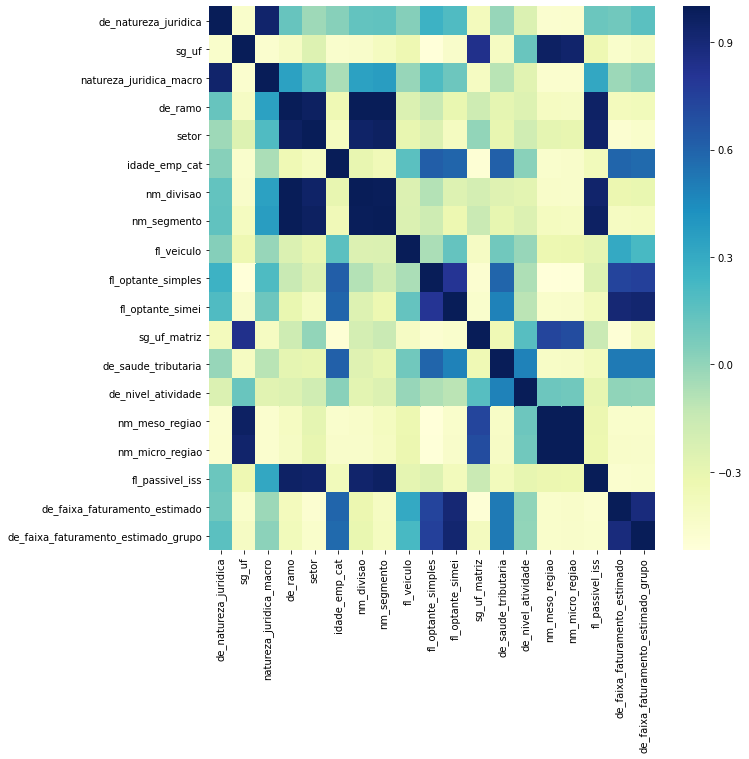

In [12]:
fig, ax = plt.subplots(figsize = (10,10))

sns.heatmap(df_corr.corr(),cmap="YlGnBu")

Evaluating the heatmap, some variables have strong relation between each other:
- de_natureza_juridica and natureza_juridica_macro. Let's maintain **"de_natureza_juridica"**
- sg_uf_matriz, nm_meso_regiao, nm_micro_regiao and sg_uf. Let's maintain **"sg_uf"**
- setor, de_ramo, nm_divisao, nm_segmento and fl_passivel_iss. Let's maintain **"setor"**
- de_faixa_faturamento_estimado and de_faixa_faturamento_estimado_grupo. Let's maintain **"de_faixa_faturamento_estimado"**

In [13]:
del df_v1_cat['natureza_juridica_macro']
del df_v1_cat['sg_uf_matriz']
del df_v1_cat['de_ramo']
del df_v1_cat['nm_divisao']
del df_v1_cat['nm_segmento']
del df_v1_cat['fl_passivel_iss']
del df_v1_cat['nm_meso_regiao']
del df_v1_cat['nm_micro_regiao']
del df_v1_cat['de_faixa_faturamento_estimado_grupo']

In [14]:
#List of the columns names (numerical and categorical)
col_num = list(df_v2_num.columns)
col_cat = list(df_v1_cat.columns)
col_total = ['ID_PF', 'id'] + col_num + col_cat
col_total

# Creating df_v2 which contains the columns that we need
df_v2 = df_v1.filter(col_total)

### Creating a sparse matrix

In [15]:
df_v3 = df_v2.set_index('id')
df_sparse = pd.get_dummies(df_v3)
df_sparse['fl_mei'] = df_sparse['fl_mei']*1
df_sparse['fl_telefone'] = df_sparse['fl_telefone']*1

With the sparse matrix created, let's fill the missing values with the mean of each variable

In [16]:
df_sparse_1 = df_sparse.fillna(df_sparse.mean())
df_sparse_1.isna().sum()

fl_mei                                                                    0
fl_telefone                                                               0
vl_total_veiculos_pesados_grupo                                           0
vl_total_veiculos_leves_grupo                                             0
nu_meses_rescencia                                                        0
                                                                         ..
de_faixa_faturamento_estimado_DE R$ 360.000,01 A R$ 1.500.000,00          0
de_faixa_faturamento_estimado_DE R$ 4.800.000,01 A R$ 10.000.000,00       0
de_faixa_faturamento_estimado_DE R$ 500.000.000,01 A 1 BILHAO DE REAIS    0
de_faixa_faturamento_estimado_DE R$ 81.000,01 A R$ 360.000,00             0
de_faixa_faturamento_estimado_SEM INFORMACAO                              0
Length: 122, dtype: int64

### Normalizing numeircal variables

In [17]:
df_num_v1 = (df_sparse_1 - df_sparse_1.mean()) / (df_sparse_1.max() - df_sparse_1.min())
df_num_v1.head()

,fl_mei,fl_telefone,vl_total_veiculos_pesados_grupo,vl_total_veiculos_leves_grupo,nu_meses_rescencia,qt_filiais,ID_PF_1,ID_PF_2,ID_PF_3,ID_PF_Generico,...,"de_faixa_faturamento_estimado_DE R$ 1.500.000,01 A R$ 4.800.000,00","de_faixa_faturamento_estimado_DE R$ 10.000.000,01 A R$ 30.000.000,00","de_faixa_faturamento_estimado_DE R$ 100.000.000,01 A R$ 300.000.000,00","de_faixa_faturamento_estimado_DE R$ 30.000.000,01 A R$ 100.000.000,00","de_faixa_faturamento_estimado_DE R$ 300.000.000,01 A R$ 500.000.000,00","de_faixa_faturamento_estimado_DE R$ 360.000,01 A R$ 1.500.000,00","de_faixa_faturamento_estimado_DE R$ 4.800.000,01 A R$ 10.000.000,00","de_faixa_faturamento_estimado_DE R$ 500.000.000,01 A 1 BILHAO DE REAIS","de_faixa_faturamento_estimado_DE R$ 81.000,01 A R$ 360.000,00",de_faixa_faturamento_estimado_SEM INFORMACAO
id,,,,,,,,,,,,,,,,,,,,,
a6984c3ae395090e3bee8ad63c3758b110de096d5d819583a784a113726db849,-0.325907,0.274706,-0.000368,-0.000398,-0.030401,-0.002971,-0.001197,-0.001221,-0.000572,0.002989,...,0.978069,-0.00385,-0.000776,-0.002612,-0.000155,-0.099779,-0.004639,-0.000088,-0.591321,-0.002534
6178f41ade1365e44bc2c46654c2c8c0eaae27dcb476c47fdef50b33f4f56f05,0.674093,0.274706,-0.000368,-0.000398,-0.242522,-0.002971,-0.001197,-0.001221,-0.000572,0.002989,...,-0.021931,-0.00385,-0.000776,-0.002612,-0.000155,-0.099779,-0.004639,-0.000088,0.408679,-0.002534
4a7e5069a397f12fdd7fd57111d6dc5d3ba558958efc02edc5147bc2a2535b08,0.674093,0.274706,-0.000368,-0.000398,0.015054,-0.002971,-0.001197,-0.001221,-0.000572,0.002989,...,-0.021931,-0.00385,-0.000776,-0.002612,-0.000155,-0.099779,-0.004639,-0.000088,-0.591321,-0.002534
3348900fe63216a439d2e5238c79ddd46ede454df7b9d8c24ac33eb21d4b21ef,-0.325907,0.274706,-0.000368,-0.000398,0.015054,-0.002971,-0.001197,-0.001221,-0.000572,0.002989,...,-0.021931,-0.00385,-0.000776,-0.002612,-0.000155,-0.099779,-0.004639,-0.000088,0.408679,-0.002534
1f9bcabc9d3173c1fe769899e4fac14b053037b953a1e4b102c769f7611ab29f,-0.325907,0.274706,-0.000368,-0.000398,0.030205,-0.002971,-0.001197,-0.001221,-0.000572,0.002989,...,-0.021931,-0.00385,-0.000776,-0.002612,-0.000155,-0.099779,-0.004639,-0.000088,0.408679,-0.002534


Separating train and test data for the 3 portfolios

In [48]:
df_pf1_train = df_num_v1[df_num_v1.index.isin(df_pf1.id)]
df_pf2_train = df_num_v1[df_num_v1.index.isin(df_pf2.id)]
df_pf3_train = df_num_v1[df_num_v1.index.isin(df_pf3.id)]

x_train1, x_test1, y_train1, y_test1 = train_test_split(df_pf1_train, df_pf1_train.index, test_size=0.5, random_state=42)
x_train2, x_test2, y_train2, y_test2 = train_test_split(df_pf2_train, df_pf2_train.index, test_size=0.5, random_state=42)
x_train3, x_test3, y_train3, y_test3 = train_test_split(df_pf3_train, df_pf3_train.index, test_size=0.5, random_state=42)

### Training and predict the model to the portfolio 1

In [49]:
model_1 = OneClassSVM(gamma='auto').fit(x_train1)

# Creating Score
score_train1 = model_1.score_samples(x_train1)
score_test1 = model_1.score_samples(x_test1)

#Predict values to the portfolio 1
predict_1 = [1 if n>=np.quantile(score_train1, 0.1) else 0 for n in score_test1]

# Accuracy of the model
result_1 = Counter(predict_1)
accuracy_1 = (result_1[1]-result_1[0])/result_1[1]
print(accuracy_1)

### Training and predict the model to the portfolio 2

In [51]:
model_2 = OneClassSVM(gamma='auto').fit(x_train2)

# Creating Score
score_train2 = model_2.score_samples(x_train2)
score_test2 = model_2.score_samples(x_test2)

#Predict values to the portfolio 2
predict_2 = [1 if n>=np.quantile(score_train2, 0.1) else 0 for n in score_test2]

# Accuracy of the model
result_2 = Counter(predict_2)
accuracy_2 = (result_2[1]-result_2[0])/result_2[1]
print(accuracy_2)

### Training and predict the model to the portfolio 3

In [53]:
# Training model to the portfolio 3
model_3 = OneClassSVM(gamma='auto').fit(x_train3)

# Creating Score
score_train3 = model_3.score_samples(x_train3)
score_test3 = model_3.score_samples(x_test3)

#Predict values to the portfolio 3
predict_3 = [1 if n>=np.quantile(score_train3, 0.1) else 0 for n in score_test3]

# Accuracy of the model
result_3 = Counter(predict_3)
accuracy_3 = (result_3[1]-result_3[0])/result_3[1]
print(accuracy_3)

### Conclusion

In this project, it was possible to check the accuracy of our model to recommend leads for a user, considering a particular customer.
It was elaborated:
- a exploratory data anaysis
- feature selection
- cleaning missing data
- data normalization
- train and test data separation
- algorithm to train our model
- model prediction and it accuracy

For our 3 portfolios, we have a great precision in our results. Portfolios 2 and 3 had more than 90% of accuracy and the Portfoliio 1 had 85%.
We can consider that this model have a good accuracy and it can be used to make recommendations.